# The Knapsack Problem 
In the knapsack problem (KP), a set of items with associated weights and values should be stored in a knapsack. The problem is to maximize the value of the items transported in the knapsack. The KP is restricted by the maximum weight the knapsack can carry. The KP is the simplest nontrivial integer programming model with binary variables, only one constraint, and positive coefficients. It is formally defined by

\begin{equation}\label{Eq.1}
\max  \sum_{i=1}^{n} p_{i} x_{i},
\end{equation}

\begin{equation}\label{Eq.2}
\sum_{i=1}^{n} w_{i} x_{i} \leq W, 
\end{equation}

where $n$ is the number of items, $p_{i}$ and $w_{i}$ is the value and weight of the $ith$ item, respectively, $x_i$ is the binary variable that represents whether the $ith$ item is in the knapsack or not, and W is the maximum weight that the knapsack can transport. 

In this tutorial, we will generate an instance of the [knapsack problem](https://en.wikipedia.org/wiki/Knapsack_problem) and solve it using the quantum approximate optimization algorithm [QAOA](https://arxiv.org/abs/1411.4028). Our goal is to undestand the different steps to encode a combinatorial optimization problem as an ising Hamiltonian, how the QAOA function works and how postprocessing the results of QAOA.

# Table of Contents

1. [Quadratic unconstrained binary optimization](#qubo)
2. [Example](#example)<br>
    2.1 [Ising Hamiltonian](#ising)<br>
    2.2 [Brute force solution](#brute_sol)
3. [QAOA](#qaoa)<br>
    3.1 [QAOA circuit](#qaoa_circ)<br>
    3.2 [Optimization](#qaoa_opt)<br>
    3.3 [Visualization](#visualization)
4. [Task 3](#task3)

## <a class="anchor" id="qubo"> </a>1. Quadratic unconstrained binary optimization (QUBO)

The set of combinatorial problems that can be represented by the QUBO formulation are characterized by functions of the form

\begin{equation}
f(\mathrm{x}) = \frac{1}{2}\sum_{i=1}^{n} \sum_{j=1}^n q_{ij} x_{i} x_{j}, \tag{1}
\end{equation}
where $n$ is the number of variables, $q_{ij} \in \mathbb{R}$ are coefficients associated to the specific problem, and $x_i \in \{0,1\}$ are the binary variables of the problem. Note that $x_{i} x_{i} \equiv x_{i}$ and $q_{ij} = q_{ji}$ in this formulation. Therefore, the general form of a combinatorial optimization problem solvable by QPUs is given by the cost function

\begin{equation}\label{QUBO_form}
f(\mathrm{x}) = \sum_{i=1}^{n-1} \sum_{j > i}^n q_{ij}x_{i}x_{j} + \sum_{i=1}^n q_{ii} x_i,\tag{2}
\end{equation}
and equality constraints given by

\begin{equation}
\sum_{i=1}^n c_i x_i = C, \ c_i \in \mathbb{R}, \tag{3}
\end{equation}
and inequality constraints given by

\begin{equation}\label{inequality}
\sum_{i=1}^n l_i x_i \ge B, \ l_i \in \mathbb{R} \tag{4}
\end{equation}

where $C$ and $R$ are constants. To transform these problems into the QUBO formulation the constraints are added as penalization terms. In this respect, the equality constraints are included in the cost function using the following penalization term

\begin{equation}\label{EQ_F}
\lambda_0 \left(\sum_{i=1}^n c_i x_i - C\right)^2,\tag{5}
\end{equation}
where $\lambda_0$ is a penalization coefficient that should be chosen to guarantee that the equality constraint is fulfilled. In the case of inequality constraint, the common approach is to use a [slack variable](https://en.wikipedia.org/wiki/Slack_variable#:~:text=In%20an%20optimization%20problem%2C%20a,constraint%20on%20the%20slack%20variable.). The slack variable, $S$, is an auxiliary variable that makes a penalization term vanish when the inequality constraint is achieved,

 \begin{equation}\label{ineq}
 \sum_{i=1}^n l_i x_i - S - B = 0.\tag{6}
 \end{equation}
 Therefore, when Eq.(\ref{inequality}) is satisfied, Eq.(\ref{ineq}) is already zero. This means the slack variable, $S$, must be in the range $0 \le S \le \max_x \sum_{i=1}^n l_i x_i - B$. To represent the $slack$ variable in binary form, the slack is decomposed in 
 binary variables: 

\begin{equation}\label{SB} 
S = \sum_{k=0}^{N-1} 2^k s_k,\tag{7}
\end{equation}
where $s_k$ are the slack binary variables. Then, the inequality constraints are added as penalization terms by 
 
 \begin{equation}\label{Ineq_EF}
 \lambda_1  \left(\sum_{i=1}^n l_i x_i - \sum_{k=0}^{N-1} 2^k s_k - B\right)^2. \tag{8}
 \end{equation}
 
Combining Eq.(\ref{QUBO_form}) and the two kinds of constraints Eq.(\ref{EQ_F}) and Eq.(\ref{Ineq_EF}), the general QUBO representation of a given combinatorial optimization problem is given by

 \begin{equation}\label{QUBO}
 \min_x \left(\sum_{i=1}^{n-1} \sum_{j > i}^nc_{ij}x_{i}x_{j} + \sum_{i=1}^n h_i x_i + \lambda_0  \left(\sum_{i=1}^n q_i x_i - C\right)^2
+  \lambda_1  \left(\sum_{i=1}^n l_i x_i - \sum_{k=0}^{N-1} 2^k s_k - B\right)^2\right). \tag{10}
 \end{equation}

Following the same principle, more constraints can be added and note that after some manipulations, Eq.(\ref{QUBO}) can be rewritten in the form of Eq.(\ref{QUBO_form}). The last step to represent the QUBO problem on QPUs is to change the $x_i$ variables to spin variables $z_i \in \{1, -1\}$ by the transformation $x_i = (1 - z_i) / 2$. Hence, Eq.(\ref{QUBO_form}) represented in terms of the cost Hamiltonian model reads

\begin{equation}\label{IsingH}
H_c(\mathrm{z}) = \sum_{i=1}^{n-1}\sum_{j>i}^n q_{ij} (1 - z_i) (1 - z_j)/4 + \sum_{i=1}^n q_{ii} (1 - z_i)/2.\tag{11}
\end{equation} 

In [1]:
from sympy import Symbol
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit import Aer
from qiskit.visualization import plot_histogram

label_size = 16
plt.rcParams['xtick.labelsize'] = label_size 
plt.rcParams['ytick.labelsize'] = label_size 
plt.rcParams['axes.labelsize'] = label_size 
plt.rcParams['legend.fontsize'] = label_size 
%matplotlib inline

### <a class="anchor" id="example"> </a>2. Example

A knapsack problem with 3 items with weights $w_i = [1, 2, 3]$, values $v_i=[5, 2, 4]$, and the knapsack maximum weight $W_{max}=3$, 

\begin{equation}\label{QUBO_form}
f(\mathrm{x}) = \sum_{i=1}^{3} v_{i}x_{i} \tag{12}
\end{equation}

and inequality constraints given by

\begin{equation}\label{inequality}
W_{max} - \sum_{i=1}^3 w_i x_i \ge 0, \tag{14}
\end{equation}

The problem has a QUBO formulation given by Eq. \ref{QUBO_K}
\begin{equation}\label{QUBO_K}
\min_x \sum_{i=1}^n -v_i x_i + \lambda_1  \left( W_{max} - \sum_{i=1}^{3}w_i x_i -\sum_{k=0}^{N-1} 2^k s_k \right)^2, \tag{15}
\end{equation}

where $N = \lceil \log_2(\max_x W_{max} - \sum_{i=1}^n w_i x_i)\rceil = \log_2(W_{max})$.

In [2]:
def Knapsack(values: list, weights: list, max_weight: int, penalty:float):
    n_items = len(values) # number of variables
    n_slacks = int(np.ceil(np.log2(max_weight))) # number of slack variables
    
    x = {i: Symbol(f"x{i}") for i in range(n_items)}  # variables that represent the items
    S = sum(2**k * Symbol(f"s{k}") for k in range(n_slacks)) # the slack variable in binary representation
    
    # objective function --------
    cost_fun = - sum([values[i]*x[i] for i in x]) # maximize the value of the items trasported Eq.12
    #(Note that minimizing the negative of cost function is the same that maximizing it)
    
    # ---------    constraint   Eq. 14  ----------
    constraint = max_weight - sum(weights[i] * x[i] for i in x) - S #inequality constraint

    cost = cost_fun + penalty * constraint**2 # Eq. 15 cost function with penalization term for the Knapsack problem
    return cost

In [3]:
values = [5, 2, 4]
weights = [1, 2, 3]
max_weight = 3
penalty = 2 #lambda_1
qubo = Knapsack(values, weights, max_weight, penalty) # Eq. 10 QUBO formulation
print(r'QUBO: min_x', qubo)

QUBO: min_x -5*x0 - 2*x1 - 4*x2 + 2*(-s0 - 2*s1 - x0 - 2*x1 - 3*x2 + 3)**2


Note that $x_{i} x_{i} \equiv x_{i}$, therefore

In [4]:
# Expanding and replacing the quadratic terms xi*xi = xi
qubo = qubo.expand().subs({symbol**2:symbol for symbol in qubo.free_symbols})
qubo

8*s0*s1 + 4*s0*x0 + 8*s0*x1 + 12*s0*x2 - 10*s0 + 8*s1*x0 + 16*s1*x1 + 24*s1*x2 - 16*s1 + 8*x0*x1 + 12*x0*x2 - 15*x0 + 24*x1*x2 - 18*x1 - 22*x2 + 18

### <a class="anchor" id="ising"> </a> 2.1 Ising Hamiltonian
The last step to represent the QUBO problem on QPUs is to change the $x_i \in \{0, 1\}$ variables to spin variables $z_i \in \{-1, 1\}$ by the transformation $x_i = (1 + z_i) / 2$ (Eq.11).

In [5]:
new_vars = {xi:(1 + Symbol(f"z{i}"))/2 for i, xi in enumerate(qubo.free_symbols)}
new_vars

{x1: z0/2 + 1/2,
 x2: z1/2 + 1/2,
 s0: z2/2 + 1/2,
 s1: z3/2 + 1/2,
 x0: z4/2 + 1/2}

In [6]:
ising_Hamiltonian = qubo.subs(new_vars)
ising_Hamiltonian = ising_Hamiltonian.expand().simplify()
print("H(z)=", ising_Hamiltonian)

H(z)= 6*z0*z1 + 2*z0*z2 + 4*z0*z3 + 2*z0*z4 + 5*z0 + 3*z1*z2 + 6*z1*z3 + 3*z1*z4 + 7*z1 + 2*z2*z3 + z2*z4 + 3*z2 + 2*z3*z4 + 6*z3 + z4/2 + 17/2


### <a class="anchor" id="brute_sol"> </a> 2.2 Brute force solution

The first option to solve the knapsack problem is to use the brute force method. This method evaluates all the possible solutions of the QUBO and returns the one with the minimum cost. However, the number of possible solutions scales as $2^n$ where $n$ is the number of items in the problem, this makes this solution unfeasible for large instances.

In [7]:
def brute_force(qubo):
    vars_ = qubo.free_symbols
    n_vars = len(vars_)
    cost = {}
    min_cost = (0, )
    for i in range(2**n_vars):
        string = np.binary_repr(i, n_vars)
        cost[string] = qubo.subs({var:s for var, s in zip(vars_, string)})
        if cost[string] < min_cost[0]:
            min_cost = (cost[string], string)
    return cost, min_cost
sol_brute = brute_force(qubo)
optimal = {var:int(s) for var, s in zip(qubo.free_symbols, sol_brute[1][1])}
sol_str = sol_brute[1][1]
print(f"Optimal result: {optimal} | cost:{sol_brute[1][0]}")

Optimal result: {x1: 0, x2: 1, s0: 0, s1: 0, x0: 1} | cost:-7


## <a class="anchor" id="qaoa"> </a>3. QAOA Circuit

Finally, we use [QAOA](https://arxiv.org/pdf/1411.4028.pdf) to find the solution to our Knapsack problem. In this case, the cost Hamiltonian, $H(z)$, obtained from the QUBO formulation, is translated into a parametric unitary gate given by

\begin{equation}\label{UC}
    U(H_c, \gamma)=e^{-i \gamma H_c},\tag{16}
\end{equation}
 where $\gamma$ is a parameter to be optimized. A second unitary operator applied is 

\begin{equation}\label{UB}
    U(B, \beta)=e^{i \beta X},\tag{17}
\end{equation}

where $\beta$ is the second parameter that must be optimized and $X = \sum_{i=1}^n \sigma_i^x$ with $\sigma_i^x$ the Pauli\-x quantum gate applied to qubit $i$. The general QAOA circuit is shown in **Fig.1**. Here, $R_X(\theta) = e^{-i \frac{\theta}{2} \sigma_x}$, $p$ represents the number of repetitions of the unitary gates Eqs.\ref{UC} and \ref{UB} with each repetition having separate values for $\gamma_p$ and $\beta_p$, and the initial state is a superposition state $| + \rangle^{\otimes n}$.

<br><center><img src="./Images/QAOA.png" width="400"><img src="./Images/Circuit_Requirements.png" width="300"><b>**Fig.1** Schematic representation of QAOA for $p$ layers. The parameters $\gamma$ and $\beta$ for each layer are the ones to be optimized. </center><br>


In [8]:
def qaoa_circuit(ising_Hamiltonian, reps=1):
    gammas = ParameterVector(r"$\gamma$", reps) # Create a set of variables gamma
    betas = ParameterVector(r"$\beta$", reps) # Create a set of variables beta
    terms_and_weights = sympy_to_dict(ising_Hamiltonian) #convert the hamiltonian into a dictionary
    num_qubits = len(ising_Hamiltonian.free_symbols) # Based on the variables 
    qc = QuantumCircuit(num_qubits) # Creating a quantum circuit
    # Apply the initial layer of Hadamard gates to all qubits
    qc.h(range(num_qubits))
    # repeat p layers the circuit shown in Fig. 1
    for p in range(reps):
        for terms, weights in terms_and_weights.items():
            if len(terms) == 1: # single-qubit terms
                qc.rz(2 * gammas[p] * float(weights), terms[0])
        for terms, weights in terms_and_weights.items():
            if len(terms) == 2: # two-qubit terms
                qc.rzz(2 * gammas[p] * float(weights), *terms)
        qc.rx(2 * betas[p], range(num_qubits)) # mixer 
    qc = qc.reverse_bits() #Because the measurement is given in reversed order
    return qc

def sympy_to_dict(ising_hamiltonian):
    ising_hamiltonian = ising_hamiltonian.expand().simplify()
    n_vars = len(ising_Hamiltonian.free_symbols)
    variables = [Symbol(f"z{i}") for i in range(n_vars)]
    hamiltonian_dict = ising_Hamiltonian.as_coefficients_dict()
    max_weight = float(np.max(np.abs(list(ising_Hamiltonian.as_coefficients_dict().values()))))
    terms_and_weights = {}
    for i in range(n_vars):
        if variables[i] in hamiltonian_dict.keys():
            terms_and_weights[(i,)] = hamiltonian_dict[variables[i]]/max_weight
        for j in range(i, n_vars):
            if variables[j] * variables[i] in hamiltonian_dict.keys():
                terms_and_weights[(i,j)] = hamiltonian_dict[variables[i]*variables[j]]/max_weight
    terms_and_weights[()] = ising_Hamiltonian.args[0] # Constant term
    return terms_and_weights

### <a class="anchor" id="qaoa_circ"> </a>3.1 QAOA quantum Circuit

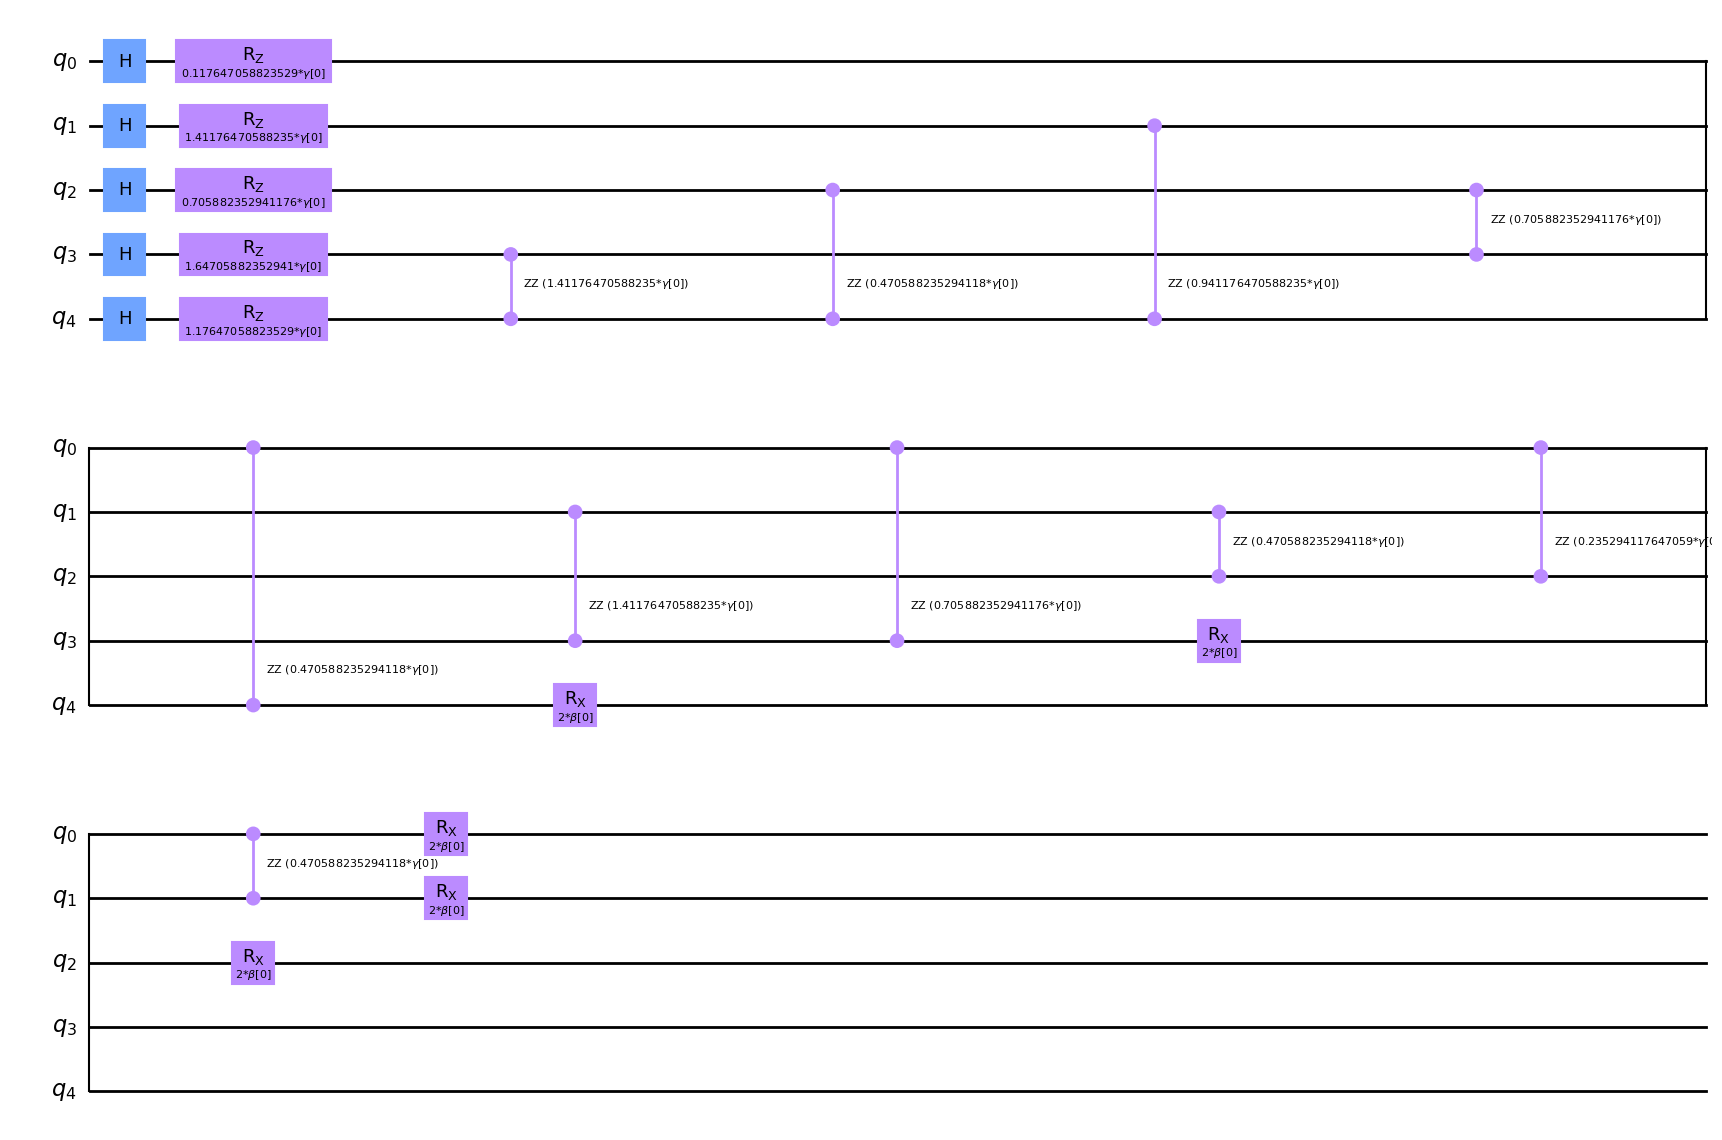

In [9]:
p = 1
qc = qaoa_circuit(ising_Hamiltonian, reps=p)
qc.draw("mpl")

### <a class="anchor" id="qaoa_opt"> </a> 3.2 Optimization 

Once we define the QAOA circuit of the combinatorial optimization problem, the next step is to find values of $\beta$ and $\gamma$ that minimize the expectation value of the Ising Hamiltonian. Here, we use Qiskit and simpy to find the minimum of cost function. In this case, we use the COBYLA optimization method with a maximum iteration equal to 200. Then, We use method Nelder-Mead to refine the solution.

In [10]:
callback_f = {"fx":[], "params":[]}
def cost_func(parameters, circuit, objective, shots=10, backend=Aer.get_backend("qasm_simulator")):
    """
    Return a cost function that depends of the QAOA circuit 

    Parameters
    ----------
    parameters : list
        gamma and beta values of the QAOA circuit.
    circuit : QuantumCircuit
        Qiskit quantum circuit of the QAOA.
    objective : sympy QUBO formulation 
        Objective function of the problem 
    shots : int, optional
        number of times the QAOA circuit is run. The default is 10.
    backend : Qiskit Backend, optional
        The default is Aer.get_backend("qasm_simulator").

    Returns
    -------
    float
        Cost of the evaluation of n string on the objective function 

    """
    cost = 0
    # running the QAOA circuit using qiskit 
    qc = circuit.copy()
    qc.measure_all()
    counts = backend.run(qc.assign_parameters(parameters=parameters), shots=shots).result().get_counts()
    # The qiskit's result is a dictionary with strings {0,1}^n as keys and count number as the value
    for sample, n_counts in counts.items():
        dict_sol = {xi:int(bi) for xi, bi in zip(objective.free_symbols, sample)}
        feval = objective.subs({xi:int(bi) for xi, bi in zip(objective.free_symbols, sample)}) #evaluate the QUBO
        cost += n_counts * float(feval)
    callback_f["fx"].append(cost/shots)
    callback_f["params"].append(parameters)
    return cost / shots


In [11]:
opt_steps = {"fx":[], "params":[]}
Nfeval = 0
def callback(parameters):
    # Saving the results of every iteration
    global Nfeval
    print('{0:4d}   {1: 3.6f}   {2: 3.6f}   {3: 3.6f}'.format(Nfeval, parameters[0], parameters[1], cost_func(parameters, qc, qubo)))
    Nfeval += 1
    opt_steps["fx"].append(cost_func(parameters, qc, qubo))
    opt_steps["params"].append(parameters)

seed = 123
np.random.seed(seed)
x0 = [0.5, 0.5] # Initial guessing
#-------- Simpy minimization method to find optimal parameters for beta and gamma
sol = minimize(cost_func, x0 = x0, args=(qc, qubo, 1000),
               callback=callback, method="COBYLA", options={"maxiter":200})
# refine the solution with a second optimization method
sol = minimize(cost_func, x0 = sol.x, args=(qc, qubo, 1000),
               callback=callback, method="nelder-mead", options={"maxiter":100})
sol


   0    1.500000    0.500000    7.000000
   1    1.500000    1.500000    9.100000
   2    2.460808    0.222785    27.600000
   3    1.980404    0.361393    29.000000
   4    1.250912    0.478669   -4.000000
   5    1.160942    0.711919    10.800000
   6    1.098241    0.280701   -0.300000
   7    1.174576    0.379685    0.200000
   8    1.217145    0.333923   -0.900000
   9    1.112139    0.382488    3.800000
  10    1.193425    0.404610   -3.200000
  11    1.160231    0.373492   -2.000000
  12    1.184737    0.367815    0.300000
  13    1.197983    0.359528   -1.400000
  14    1.179522    0.361999   -1.700000
  15    1.180864    0.358330    1.700000
  16    1.176435    0.364392    5.200000
  17    1.181126    0.363113    1.800000
  18    1.179416    0.361028   -3.900000
  19    1.178620    0.362374   -0.200000
  20    1.180006    0.362060   -0.600000
  21    1.179282    0.362045    0.600000
  22    1.179503    0.361755    5.700000
  23    1.179583    0.361524   -1.200000
  24    1.179

 final_simplex: (array([[1.17953613, 0.3797818 ],
       [1.17953613, 0.3797818 ],
       [1.17953613, 0.3797818 ]]), array([-1.078, -0.45 , -0.221]))
           fun: -1.078
       message: 'Maximum number of iterations has been exceeded.'
          nfev: 283
           nit: 100
        status: 2
       success: False
             x: array([1.17953613, 0.3797818 ])

### <a class="anchor" id="visualization"> </a> 3.3 Results visualization

#### Optimization steps (Ising Hamiltonian expectation value)

Text(0.5, 1.0, 'QAOA')

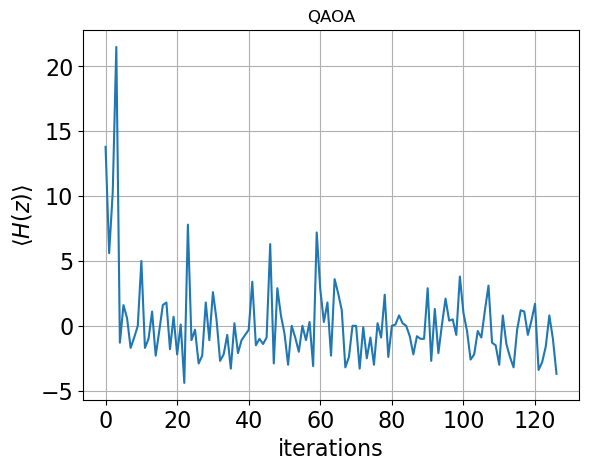

In [12]:
# expectation value vs. iterations
fig, ax = plt.subplots()
ax.plot(opt_steps["fx"])
ax.set_xlabel("iterations")
ax.set_ylabel(r"$\langle H(z)\rangle$")
ax.grid()
ax.set_title("QAOA")

#### Histogram visualization: 50 Shots of the QAOA circuit with optimal parameters

Text(0.5, 1.0, 'QAOA with optimized parameters solutions count')

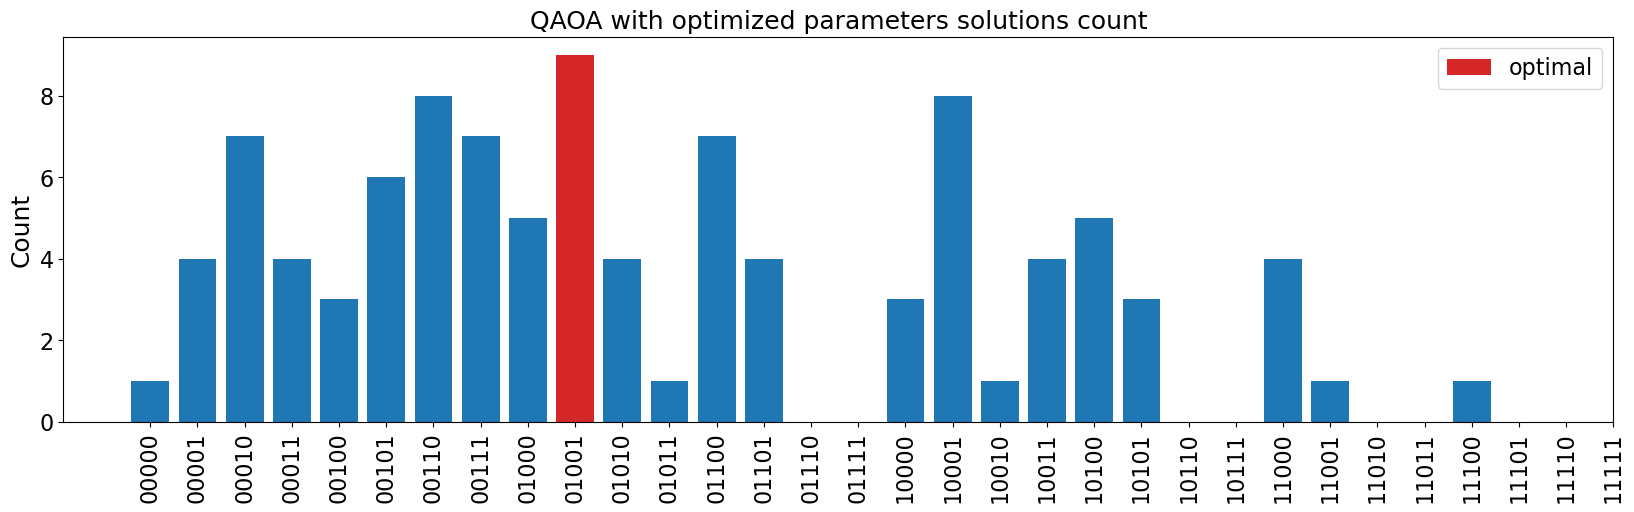

In [13]:
# Use the Aer simulator with 50 shots to find the distribution of solutions. Note that not all of them are valid solutions.
# Remember that QAOA in general does not find the optimal solution but a probability distribution where optimal and suboptimal
# solutions are more probable in general.
backend = Aer.get_backend("qasm_simulator")
qc_eval = qc.copy() # Create a copy of our qiskit quantum circuit
qc_eval.measure_all() # Measure all the qubits
results = backend.run(qc_eval.assign_parameters(parameters=sol.x), shots=100).result().get_counts() #Run the circuit on qasm_simulator backend
opt_res = {sol_str:results[sol_str]} #times the optimal solution is found
# results.pop(sol_str[::-1])
# plot_histogram is a qiskit function
fig, ax = plt.subplots(figsize=(20,5))
ax.bar([int(k, 2) for k in results.keys()], results.values())
ax.bar([int(k, 2) for k in results.keys() if k in opt_res], [v for k, v in results.items() if k in opt_res], color="tab:red", label="optimal")
ax.set_xticks(range(2**len(qubo.free_symbols)))
ticks = ax.set_xticklabels([np.binary_repr(i, len(qubo.free_symbols)) for i in range(2**len(qubo.free_symbols))], rotation=90)
ax.set_ylabel("Count", fontsize=18)
ax.legend()
ax.set_title("QAOA with optimized parameters solutions count", fontsize=18)

In [14]:
# statevector_simulator gives us the exact solution of QAOA, additionally, from it, we can get the probabilities.
backend = Aer.get_backend("statevector_simulator")
probabilities = backend.run(qc.assign_parameters(parameters=sol.x)).result().get_statevector().probabilities()
print(f"Probability of finding the optimal solution using QAOA: {100*np.round(probabilities[int(sol_str,2)],4)}%")
print(f"Random guessing: {100/2**len(sol_str)}%")

Probability of finding the optimal solution using QAOA: 7.41%
Random guessing: 3.125%


## Landscape

For the case where there is just one layer on the QAOA, we can visualize the energy expectation value $\langle H(z) \rangle$ for the knapsack problem. The Figure below shows the landscape for the Knapsack problem with the optimal solution of the optimization step.

In [15]:
n1 = n2 = 50
gammas = np.linspace(0, np.pi, n1)
betas = np.linspace(-np.pi/2, np.pi/2, n2)

landscape = np.zeros((n1, n2))
circ = qc.copy()
circ.measure_all()
for i in range(n1):
    for j in range(n2):
        landscape[i,j] = cost_func([gammas[i], betas[j]], circ, qubo, 100)

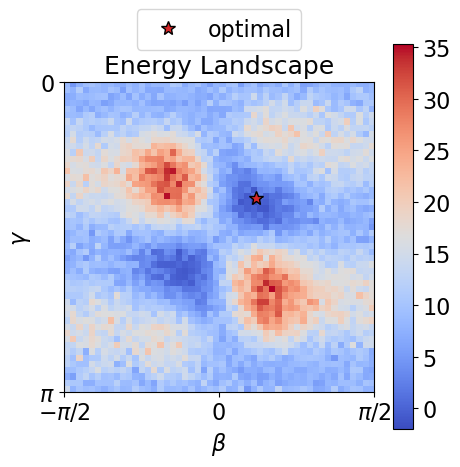

In [16]:
fig, ax = plt.subplots(figsize=(5,5))
ax1 = ax.imshow(landscape, cmap="coolwarm", extent=[-np.pi/2, np.pi/2, np.pi, 0])
ax.plot(sol.x[1], sol.x[0], marker="*", markersize=10, markeredgecolor="black", color="tab:red", label="optimal", linewidth=0)

ax.set_xticks([-np.pi/2, 0, np.pi/2])
ax.set_yticks([0,np.pi])
ax.set_xticklabels([r"$-\pi/2$", 0, r"$\pi/2$"])
ax.set_yticklabels([0, r"$\pi$"])
ax.set_xlabel(r"$\beta$")
ax.set_ylabel(r"$\gamma$")
ax.legend(loc='upper center', bbox_to_anchor=(0.5,1.27))
ax.set_title("Energy Landscape", fontsize=18)
plt.colorbar(ax1)

## <a class="anchor" id="task3"></a> Exercise (Optional)

In this excercise you must repeat the knapsack problem this time with some modifications. Now, we need to maximize the value transported on a knapsack with 6 items with weights $w = [7, 2, 1, 3, 2, 5]$, values $v = [4, 3, 2, 1, 5, 3]$, and maximum weight $W_{max} = 15$. An additional restriction in this case is that just one of the items $[x_1, x_3, x_5]$ could be in the knapsack.

\begin{equation}
x_1 + x_3 + x_5 = 1
\end{equation}

1. Repeat the steps in [**Example**](#example) and [**QAOA**](#qaoa) for this problem (note that you should modify the qubo formulation to include the equality constraint.)

2. Run it on a [fake backend](https://qiskit.org/documentation/apidoc/providers_fake_provider.html) to simulate what happen on a real quantum device. Please use the fakle backend of `ibmq_guadalupe`

In [20]:
from sympy import Symbol
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit import Aer
from qiskit.visualization import plot_histogram
from qiskit import transpile

label_size = 16
plt.rcParams['xtick.labelsize'] = label_size 
plt.rcParams['ytick.labelsize'] = label_size 
plt.rcParams['axes.labelsize'] = label_size 
plt.rcParams['legend.fontsize'] = label_size 
%matplotlib inline

from qiskit.providers.fake_provider import FakeGuadalupeV2


In [21]:
backend_noise = FakeGuadalupeV2()

In [22]:
def knapsack_new(values, weights, max_weight):
    n_items = len(values) # number of variables
    n_slacks = int(np.ceil(np.log2(max_weight))) # number of slack variables

    x = {i: Symbol(f"x{i}") for i in range(n_items)}  # variables that represent the items
    S = sum(2**k * Symbol(f"s{k}") for k in range(n_slacks)) # the slack variable in binary representation

    # objective function --------
    cost_fun = - sum([values[i]*x[i] for i in x]) # maximize the value of the items trasported Eq.12
    #(Note that minimizing the negative of cost function is the same that maximizing it)

    # ---------    constraint   Eq. 14  ----------
    constraint1 = max_weight - sum(weights[i] * x[i] for i in x) - S #inequality constraint

    constraint2 = x[1]  - 1

    cost = cost_fun + 2 * constraint1 ** 2  + 10 * constraint2 ** 2# Eq. 15 cost function with penalization term for the Knapsack problem
    return cost

In [23]:
weights = [7, 2, 1, 3, 2, 5]
values = [4, 3, 2, 1, 5, 3]
max_weight = 15

qubo = knapsack_new(values, weights, max_weight)

qubo = qubo.expand().subs({symbol**2:symbol for symbol in qubo.free_symbols})
qubo

8*s0*s1 + 16*s0*s2 + 32*s0*s3 + 28*s0*x0 + 8*s0*x1 + 4*s0*x2 + 12*s0*x3 + 8*s0*x4 + 20*s0*x5 - 58*s0 + 32*s1*s2 + 64*s1*s3 + 56*s1*x0 + 16*s1*x1 + 8*s1*x2 + 24*s1*x3 + 16*s1*x4 + 40*s1*x5 - 112*s1 + 128*s2*s3 + 112*s2*x0 + 32*s2*x1 + 16*s2*x2 + 48*s2*x3 + 32*s2*x4 + 80*s2*x5 - 208*s2 + 224*s3*x0 + 64*s3*x1 + 32*s3*x2 + 96*s3*x3 + 64*s3*x4 + 160*s3*x5 - 352*s3 + 56*x0*x1 + 28*x0*x2 + 84*x0*x3 + 56*x0*x4 + 140*x0*x5 - 326*x0 + 8*x1*x2 + 24*x1*x3 + 16*x1*x4 + 40*x1*x5 - 125*x1 + 12*x2*x3 + 8*x2*x4 + 20*x2*x5 - 60*x2 + 24*x3*x4 + 60*x3*x5 - 163*x3 + 40*x4*x5 - 117*x4 - 253*x5 + 460

In [24]:
sol_brute = brute_force(qubo)
optimal = {var:int(s) for var, s in zip(qubo.free_symbols, sol_brute[1][1])}
sol_str = sol_brute[1][1]
print(f"Optimal result: {optimal} | cost:{sol_brute[1][0]}")

Optimal result: {s1: 0, x3: 1, s2: 0, x1: 1, s0: 0, x2: 1, x0: 1, x4: 1, x5: 0, s3: 0} | cost:-15


In [25]:
new_vars = {xi:(1 + Symbol(f"z{i}"))/2 for i, xi in enumerate(qubo.free_symbols)}
ising_Hamiltonian = qubo.subs(new_vars)
ising_Hamiltonian = ising_Hamiltonian.expand().simplify()
print("H(z)=", ising_Hamiltonian)

H(z)= 6*z0*z1 + 8*z0*z2 + 4*z0*z3 + 2*z0*z4 + 2*z0*z5 + 14*z0*z6 + 4*z0*z7 + 10*z0*z8 + 16*z0*z9 + 10*z0 + 12*z1*z2 + 6*z1*z3 + 3*z1*z4 + 3*z1*z5 + 21*z1*z6 + 6*z1*z7 + 15*z1*z8 + 24*z1*z9 + 29*z1/2 + 8*z2*z3 + 4*z2*z4 + 4*z2*z5 + 28*z2*z6 + 8*z2*z7 + 20*z2*z8 + 32*z2*z9 + 20*z2 + 2*z3*z4 + 2*z3*z5 + 14*z3*z6 + 4*z3*z7 + 10*z3*z8 + 16*z3*z9 + 7*z3/2 + z4*z5 + 7*z4*z6 + 2*z4*z7 + 5*z4*z8 + 8*z4*z9 + 5*z4 + 7*z5*z6 + 2*z5*z7 + 5*z5*z8 + 8*z5*z9 + 4*z5 + 14*z6*z7 + 35*z6*z8 + 56*z6*z9 + 33*z6 + 10*z7*z8 + 16*z7*z9 + 15*z7/2 + 40*z8*z9 + 47*z8/2 + 40*z9 + 97


In [26]:
p = 1
qc_new = qaoa_circuit(ising_Hamiltonian, reps=p)
# qc_new.draw("mpl")

In [ ]:
n1 = n2 = 25
gammas = np.linspace(0, np.pi, n1)
betas = np.linspace(-np.pi/2, np.pi/2, n2)

landscape = np.zeros((n1, n2))
landscape_noise = np.zeros((n1, n2))

circ = qc_new.copy()
circ.measure_all()
for i in range(n1):
    print(f" i: {i}")
    for j in range(n2):
        landscape_noise[i,j] = cost_func([gammas[i], betas[j]], circ, qubo, 100, backend_noise)
        landscape[i,j] = cost_func([gammas[i], betas[j]], circ, qubo, 100)

Text(0.5, 1.0, 'Energy Landscape noisy')

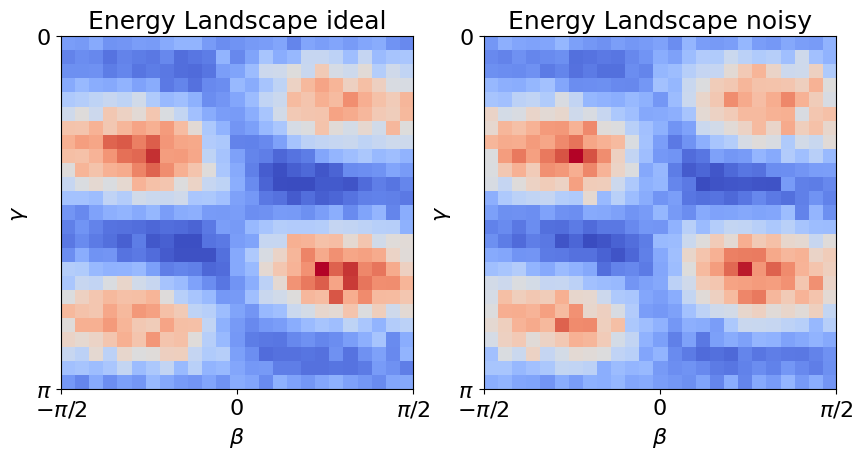

In [50]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax1 = ax[0].imshow(landscape, cmap="coolwarm", extent=[-np.pi/2, np.pi/2, np.pi, 0])
ax1 = ax[1].imshow(landscape_noise, cmap="coolwarm", extent=[-np.pi/2, np.pi/2, np.pi, 0])
for i in range(2):
    ax[i].set_xticks([-np.pi/2, 0, np.pi/2])
    ax[i].set_yticks([0,np.pi])
    ax[i].set_xticklabels([r"$-\pi/2$", 0, r"$\pi/2$"])
    ax[i].set_yticklabels([0, r"$\pi$"])
    ax[i].set_xlabel(r"$\beta$")
    ax[i].set_ylabel(r"$\gamma$")
    # ax[i].legend(loc='upper center', bbox_to_anchor=(0.5,1.27))
ax[0].set_title("Energy Landscape ideal", fontsize=18)
ax[1].set_title("Energy Landscape noisy", fontsize=18)


In [56]:
opt_steps = {"fx":[], "params":[]}
Nfeval = 0
def callback(parameters):
    # Saving the results of every iteration
    global Nfeval
    print('{0:4d}   {1: 3.6f}   {2: 3.6f}   {3: 3.6f}'.format(Nfeval, parameters[0], parameters[1], cost_func(parameters, qc_new, qubo)))
    Nfeval += 1
    opt_steps["fx"].append(cost_func(parameters, qc_new, qubo))
    opt_steps["params"].append(parameters)

seed = 123
np.random.seed(seed)
x0 = [0.5, 0.5] # Initial guessing
#-------- Simpy minimization method to find optimal parameters for beta and gamma
sol = minimize(cost_func, x0 = x0, args=(qc_new, qubo, 100, backend_noise),
               callback=callback, method="COBYLA", options={"maxiter":200})
#refine the solution with a second optimization method
sol = minimize(cost_func, x0 = sol.x, args=(qc_new, qubo, 100, backend_noise),
               callback=callback, method="nelder-mead", options={"maxiter":100})
sol


   0    1.500000    0.500000    96.900000
   1    1.500000    1.500000    37.500000
   2    2.490284    0.360942    187.300000
   3    1.995142    0.430471    302.500000
   4    1.250453    0.484949    40.500000
   5    1.005709    0.433957    49.300000
   6    1.257979    0.360176    35.100000
   7    1.003683    0.525001    136.600000
   8    1.127068    0.504975    59.000000
   9    1.056696    0.608284    77.700000
  10    1.113488    0.443968    81.100000
  11    1.125135    0.536165    47.400000
  12    1.157852    0.499597    30.100000
  13    1.118540    0.491882    16.500000
  14    1.127397    0.512780    39.400000
  15    1.134367    0.502190    68.800000
  16    1.124291    0.502227    30.500000
  17    1.127255    0.506919    37.700000
  18    1.128734    0.503955    33.000000
  19    1.126179    0.504570    46.400000
  20    1.127183    0.505449    71.000000
  21    1.127373    0.504593    69.700000
  22    1.126827    0.504933    82.100000
  23    1.127157    0.504929   

 final_simplex: (array([[1.12720965, 0.50489921],
       [1.12720965, 0.50489921],
       [1.12720965, 0.50489921]]), array([26.4 , 47.73, 71.34]))
           fun: 26.4
       message: 'Maximum number of iterations has been exceeded.'
          nfev: 286
           nit: 100
        status: 2
       success: False
             x: array([1.12720965, 0.50489921])

Text(0.5, 1.0, 'QAOA')

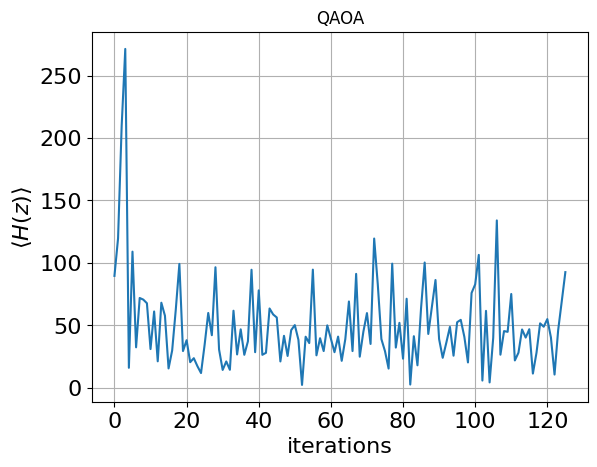

In [57]:
# expectation value vs. iterations
fig, ax = plt.subplots()
ax.plot(opt_steps["fx"])
ax.set_xlabel("iterations")
ax.set_ylabel(r"$\langle H(z)\rangle$")
ax.grid()
ax.set_title("QAOA")